
 2022-10-23

데이콘 경진대회 1등 솔루션 참고 리뷰. 

# 퇴근시간 버스 승차인원 예측 경진대회


## 00. 분석환경 구축

활용라이브러리
- scikit- learn 활용
- xgboost
- lightgbm
- geopy
- tqdm

In [1]:
# pandas 설치
!pip install pandas
# numpy 설치
!pip install numpy
# seaborn 설치
!pip install seaborn
# scikit-learn 설치
!pip install scikit-learn
# geopy 설치
!pip install geopy
# XGBoost 설치
!pip install xgboost
# lightGBM 설치
!pip install lightgbm

## 01. 탐색적 데이터 분석

### 1. Data Load

데이터상의 한계 (해당범위 이외의 데이터를 학습에 사용하면 데이터 누수로 실격처리됨)
- 오전시간 데이터를 활용해 퇴근시간 버스 승차인원을 예측해야함.
- 9월 한달간의 데이터를 활용해 10월 15일간의 퇴근시간을 예측해야함.

In [7]:
import pandas as pd

# 데이터 로드
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
bts= pd.read_csv('data/bus_bts.csv')
jeju_life = pd.read_csv('data/jeju_financial_life_data.csv')
weather = pd.read_csv('data/weather.csv', encoding='cp949')
rain = pd.read_csv('data/rain.csv', encoding='utf-8')

In [4]:
# 학습 데이터 상위 5줄 출력
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
# 학습 데이터 정보 출력
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

In [6]:
# bus_bts 데이터 상위 5줄 출력
bts.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


In [7]:
# bus_bts 데이터 정보 출력
bts.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409414 entries, 0 to 2409413
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   user_card_id         2409414 non-null  float64
 1   bus_route_id         2409414 non-null  int64  
 2   vhc_id               2409414 non-null  int64  
 3   geton_date           2409414 non-null  object 
 4   geton_time           2409414 non-null  object 
 5   geton_station_code   2409414 non-null  int64  
 6   geton_station_name   2409365 non-null  object 
 7   getoff_date          1513678 non-null  object 
 8   getoff_time          1513678 non-null  object 
 9   getoff_station_code  1513678 non-null  float64
 10  getoff_station_name  1513639 non-null  object 
 11  user_category        2409414 non-null  int64  
 12  user_count           2409414 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 239.0+ MB


In [8]:
# jeju_financial_life_data 데이터 상위 5줄 출력
jeju_life.head()

,zip_cd,year_month,x_axis,y_axis,sex,age,job_majorc,job_smallc,job_public,job_profession,...,avg_debt,avg_debt_credit,avg_debt_noneb,avg_debt_mortgage,avg_debt_deposit,avg_debt_collateral,avg_credit_rat,medium_resid_rat,large_resid_rat,vehicle_own_rat
0,63299,201902,126.565889,33.513210,1,54,0.0,0.166667,0.000000,0.000000,...,24285196,11419148,8863595,55550000,0,55550000,5,-999999.0,-999999.0,0.000000
1,63560,201902,126.497121,33.247225,1,59,0.0,0.125000,0.000000,0.000000,...,108571077,25896955,13317443,0,200000000,74421721,4,-999999.0,-999999.0,0.000000
2,63560,201902,126.497121,33.247225,2,49,0.0,0.250000,0.000000,0.000000,...,26424335,12015311,12015311,40833359,0,40833359,2,-999999.0,-999999.0,0.000000
3,63560,201902,126.497121,33.247225,1,54,0.0,0.181818,0.090909,0.090909,...,647716901,39952556,21558153,36697792,0,706300496,4,-999999.0,-999999.0,0.166667
4,63560,201902,126.497121,33.247225,1,49,0.0,0.250000,0.000000,0.000000,...,248232725,35712501,5568751,0,0,626810674,5,-999999.0,-999999.0,0.000000


In [9]:
# jeju_financial_life_data 데이터 정보 출력
jeju_life.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10422 entries, 0 to 10421
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zip_cd               10422 non-null  int64  
 1   year_month           10422 non-null  int64  
 2   x_axis               10422 non-null  float64
 3   y_axis               10422 non-null  float64
 4   sex                  10422 non-null  int64  
 5   age                  10422 non-null  int64  
 6   job_majorc           10422 non-null  float64
 7   job_smallc           10422 non-null  float64
 8   job_public           10422 non-null  float64
 9   job_profession       10422 non-null  float64
 10  job_self             10422 non-null  float64
 11  job_none             10422 non-null  float64
 12  job_other            10422 non-null  float64
 13  avg_income           10422 non-null  int64  
 14  med_income           10422 non-null  int64  
 15  avg_spend            10422 non-null 

In [10]:
# weather 데이터 상위 5줄 출력
weather.head()

,날짜,현재일기,현재기온,체감온도,일강수
0,2019-09-01,흐림,26.2,75.0,0
1,2019-09-02,비 끝남,22.5,72.0,25.7
2,2019-09-03,흐림,25.4,77.0,12.1
3,2019-09-04,약한비단속,24.2,75.0,34.3
4,2019-09-05,구름많음,27.6,79.0,0.1


In [11]:
# weather 데이터 정보 출력
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      46 non-null     object 
 1   현재일기    46 non-null     object 
 2   현재기온    46 non-null     float64
 3   체감온도    46 non-null     float64
 4   일강수     46 non-null     object 
dtypes: float64(2), object(3)
memory usage: 1.9+ KB


In [12]:
# rain 데이터 상위 5줄 출력
rain.head()

,지점,일시,기온(°C),강수량(mm)
0,gosan,2019-09-01,23.916667,0.00
1,gosan,2019-09-02,23.700000,12.10
2,gosan,2019-09-03,23.550000,1.90
3,gosan,2019-09-04,23.533333,12.84
4,gosan,2019-09-05,26.033333,0.00


In [13]:
# rain 데이터 정보 출력
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   지점       184 non-null    object 
 1   일시       184 non-null    object 
 2   기온(°C)   184 non-null    float64
 3   강수량(mm)  66 non-null     float64
dtypes: float64(2), object(2)
memory usage: 5.9+ KB


### 2. Data EDA

In [18]:
# 시각화에 필요한 라이브러리 임포트
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib inline # 내부에 결과를 출력하도록 설정

#한글폰트 깨짐 처리
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

# 마이너스 기호 출력
plt.rc('axes', unicode_minus=False) 

# 분석에 문제가 없는 경고 메세지는 숨긴다.
import warnings
warnings.filterwarnings('ignore') 

In [9]:
# 학습 데이터 복사본 생성
traindata = train.copy()

#### (1) visualization을 통한 타깃 변수 분포 확인 

variation 확인방법
- (1) numpy의 var()함수 이용
- (2) statistics의  함수 이용   ( https://docs.python.org/ko/3/library/statistics.html )

  pvariance(): 모집단의 분산 / variance() : 표본의 분산 를 이용
  


- (3) visualization : matplotlib의 histogram 확인
- (4) visualization : seaborn의 함수 이용 
( https://datascienceschool.net/01%20python/05.04%20%EC%8B%9C%EB%B3%B8%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%ED%8F%AC%20%EC%8B%9C%EA%B0%81%ED%99%94.html )
   
  * 1차원 데이터 
  
  : 실수값 -> 1차원 실수 플롯(kdeplot()/ rugplot()/ distplot()) 
  
  : 카테고리값 -> 카운트 플롯(countplot())

  * 2차원 데이터 

  : 데이터가 2차원이고 모두 연속인 실수값   2차원 실수플롯(joinplot())

  : 데이터가 모두 카테고리 값 -> heatmap()

  : 데이터가 실수값과 카테고리값이 섞여 있는 경우 -> barplot() / boxplot()/ pointplot() / violinplot() / stripplot() / swarmplot()

    ** varplot, violinplot, boxplot 의 경우 hue 인수를 이용해 카테고리별 다르게 시각화 가능
  
  * 3차원 데이터
  
  : 실수값 -> pairplot()

  : 카테고리값 -> catplot()

  : 카테고리값이 섞여있는 경우 -> pairplot(data, hue='category_name', markers=['o','s','d']) ; 카테고리변수마다 색상다르게 설정

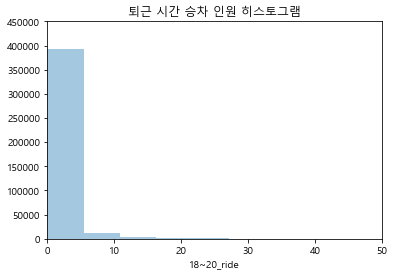

In [16]:
# 타깃 변수(퇴근 시간 승차 인원) 분포 시각화
sns.distplot(traindata['18~20_ride'], kde = False, bins = 50)
plt.axis([0, 50, 0, 450000]) # [x 축 최솟값, x 축 최댓값, y 축 최솟값, y 축 최댓값]
plt.title("퇴근 시간 승차 인원 히스토그램") # 그래프 제목 지정
plt.show() # 그래프 그리기

In [17]:
# 타깃 변수(퇴근 시간 승차 인원) 분포 확인
traindata.groupby('18~20_ride').size().head(6)

18~20_ride
0.0    296528
1.0     44268
2.0     23752
3.0     13560
4.0      8630
5.0      5911
dtype: int64

#### (2) 단일 변수에 따른 타깃 변수의 변화

In [10]:
# 요일 변수 생성

# 날짜형으로 변환
traindata['date'] = pd.to_datetime(traindata['date'])
# 요일을 문자형으로 추출해 변수 생성
traindata['weekday'] = traindata['date'].dt.strftime('%a')

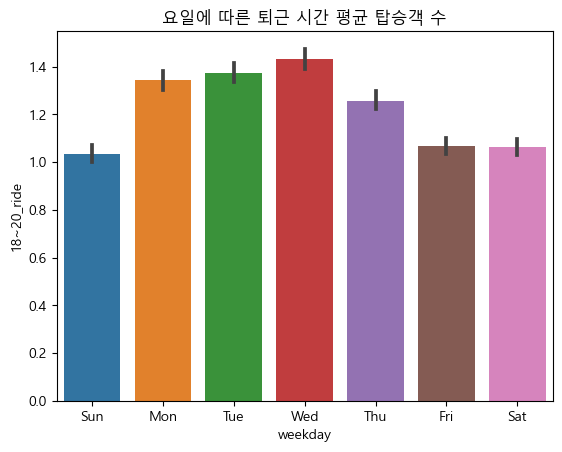

In [19]:
# 요일별 퇴근 시간 평균 탑승객 수 시각화
sns.barplot(x="weekday", y="18~20_ride", data=traindata)
plt.title("요일에 따른 퇴근 시간 평균 탑승객 수")
plt.show()

월~ 수 : 증가 , 수~ 토 : 감소추세

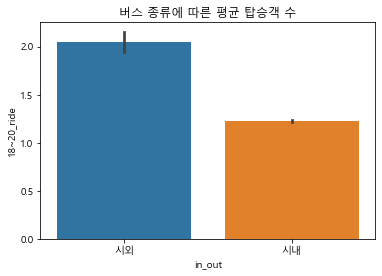

In [20]:
# 버스 종류별 퇴근 시간 평균 탑승객 수 시각화
sns.barplot(x="in_out", y="18~20_ride", data=traindata)
plt.title("버스 종류에 따른 평균 탑승객 수")
plt.show()

시외버스와 시내버스 따라 퇴근시간 버스 이용객수에 차이가 있음

In [21]:
# 일별 출퇴근 시간의 총 승차 인원 데이터 생성
traindata['8~10_ride'] = traindata['8~9_ride'] + traindata['9~10_ride']
eda_data = traindata.groupby('date')[['18~20_ride','8~10_ride']].agg('sum'
                                                                    ).reset_index()
# 상위 5개 행 확인
eda_data.head()

,date,18~20_ride,8~10_ride
0,2019-09-01,11537.0,11957.0
1,2019-09-02,20561.0,21844.0
2,2019-09-03,19743.0,25756.0
3,2019-09-04,20133.0,21472.0
4,2019-09-05,20392.0,26331.0


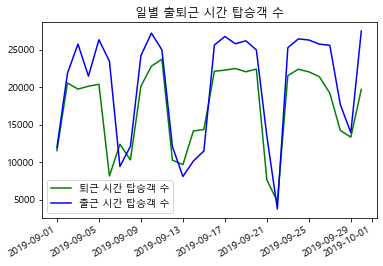

In [22]:
# 일별 출퇴근 시간 탑승객 수 시각화
plt.plot("date", "18~20_ride", "g-", label = "퇴근 시간 탑승객 수", data=eda_data)
plt.plot("date", "8~10_ride", "b-", label = "출근 시간 탑승객 수", data=eda_data)
plt.gcf().autofmt_xdate() # x축의 라벨이 서로 겹치지 않도록 설정
plt.legend(loc=0) # 그래프 상에서 최적의 위치에 범례 표시
plt.title("일별 출퇴근 시간 탑승객 수")   
plt.show()

출퇴근 시간의 일별 탑승객 수는 비슷한 양상을 띄며 일별로 패턴이 있는 시계열 자료임

## 02. 데이터 전처리

### 01. 내부 데이터를 통한 변수 생성

#### (1) EDA시 확인한 결과를 바탕으로 활용변수를 추가

* 요일을 나타내는 변수(weekday)

In [ ]:
# datetime 변수형으로 변환
df['date'] = pd.to_datetime(df['date'])
# 요일 추출 (0-월요일~6-일요일)
df['weekday'] = df['date'].dt.weekday

In [ ]:
df[['weekday']].head()

,weekday
0,6
1,6
2,6
3,6
4,6


* 요일별 평균 탑승객 수

In [ ]:
# 요일별 평균 탑승 승객수를 구하는 함수
def week_mean() :
    # 전체 데이터에서 train 데이터에 해당하는 행 추출
    train_data = df.query('cue==0').reset_index(drop=True)
    
    # 일괄적으로 1의 값을 가지는 'weekdaymean'변수 생성
    df['weekdaymean'] = 1

    # 각 요일에 해당하는 인덱스 추출
    index0 = df.query('weekday==0').index
    index1 = df.query('weekday==1').index
    index2 = df.query('weekday==2').index
    index3 = df.query('weekday==3').index
    index4 = df.query('weekday==4').index
    index5 = df.query('weekday==5').index
    index6 = df.query('weekday==6').index

    # 인덱스를 활용하여 'weekdaymean'의 값을 각 요일에 맞는 평균 탑승 승객수로 변경 
    df.iloc[index0,-1] = train_data.query('weekday==0')['18~20_ride'].mean()
    df.iloc[index1,-1] = train_data.query('weekday==1')['18~20_ride'].mean()
    df.iloc[index2,-1] = train_data.query('weekday==2')['18~20_ride'].mean()
    df.iloc[index3,-1] = train_data.query('weekday==3')['18~20_ride'].mean()
    df.iloc[index4,-1] = train_data.query('weekday==4')['18~20_ride'].mean()
    df.iloc[index5,-1] = train_data.query('weekday==5')['18~20_ride'].mean()
    df.iloc[index6,-1] = train_data.query('weekday==6')['18~20_ride'].mean()
    
    return df

# 함수를 실행하여 변수 생성
df = week_mean()

In [ ]:
df[['weekdaymean']].head()

,weekdaymean
0,1.034282
1,1.034282
2,1.034282
3,1.034282
4,1.034282


* 버스 종류별 평균 탑승객 수

In [ ]:
# 버스 종류별 평균 탑승 승객수를 구하는 함수
def inout_mean() :
    # 전체 데이터에서 train 데이터에 해당하는 행 추출
    train_data = df.query('cue==0').reset_index(drop=True)
    
    # 일괄적으로 1의 값을 가지는 in_out_mean 변수 생성
    df['in_out_mean'] = 1

    # 버스 종류별 인덱스 추출
    in_index = df.query('in_out == "시내"').index # 시내버스
    out_index = df.query('in_out == "시외"').index # 시외버스

    # 인덱스를 활용하여 in_out_mean의 값을 각 버스 종류에 맞는 
    # 평균 탑승 승객수로 변경
    df.iloc[in_index,-1] = train_data.query('in_out == "시내"')['18~20_ride'].mean()
    df.iloc[out_index,-1] = train_data.query('in_out == "시외"')['18~20_ride'].mean()
    
    return df

# 함수를 실행하여 변수 생성
df = inout_mean()

In [ ]:
df[['in_out_mean']].head()

,in_out_mean
0,2.044345
1,2.044345
2,2.044345
3,1.228499
4,1.228499


* 일별 오전 시간대의 총 탑승객 수

In [ ]:
# 날짜별 오전시간에 탑승한 총 승객수
f=df.groupby('date')['6~7_ride','7~8_ride','8~9_ride','9~10_ride','10~11_ride'
                    ].sum().reset_index()

# 변수명 바꾸기
f.columns=['date','6~7_ride_sum','7~8_ride_sum','8~9_ride_sum','9~10_ride_sum',
           '10~11_ride_sum']

# 기존의 데이터프레임에 새로운 변수를 병합
df = pd.merge(df, f, how='left', on='date')

In [ ]:
df[['date','6~7_ride_sum','7~8_ride_sum','8~9_ride_sum','9~10_ride_sum',
    '10~11_ride_sum']].head()

,date,6~7_ride_sum,7~8_ride_sum,8~9_ride_sum,9~10_ride_sum,10~11_ride_sum
0,2019-09-01,2942.0,4518.0,5682.0,6275.0,6774.0
1,2019-09-01,2942.0,4518.0,5682.0,6275.0,6774.0
2,2019-09-01,2942.0,4518.0,5682.0,6275.0,6774.0
3,2019-09-01,2942.0,4518.0,5682.0,6275.0,6774.0
4,2019-09-01,2942.0,4518.0,5682.0,6275.0,6774.0


#### (2) 도메인 조사를 통한 변수

* 배차 간격

수요가 많은 버스에 차량을 많이 추입해 배차간격을 줄이는 특성을 반영하기 위함.

-> 탑승 날짜와 탑승 정류장 코드, 탑승 노선 번호와 i번째 탑승자와 i+1번째 탑승자의 시간차 를 확인하여 배차간격을 추정

배차간격이 짧을 수록 수요가 많은 버스이므로 결측치는 0이 아닌, 9999로 채움.

In [ ]:
# 탑승 날짜를 datetime형으로 변환
bts['geton_time2'] = pd.to_datetime(bts['geton_time'])

# 탑승 날짜, 탑승 정류장 코드, 탑승 노선 번호 기준으로 정렬
f = bts.sort_values(by=['geton_date','geton_station_code','bus_route_id',
                        'geton_time2'],ascending=True).reset_index()

In [ ]:
# 반복문 실행 시간이 많이 소요되어 상태 진행률을 확인할 수 있는 tqdm 라이브러리 사용
from tqdm import notebook

# 시차를 넣기 위한 빈 리스트 생성
interval_lst = []
for i in notebook.tqdm(range(0,len(f)-1)):
    # 탑승 날짜, 탑승 정류장 코드, 탑승 노선 번호가 같다면
    if ((f.iloc[i].geton_date == f.iloc[i+1].geton_date) & 
        (f.iloc[i].geton_station_code == f.iloc[i+1].geton_station_code) & 
        (f.iloc[i].bus_route_id == f.iloc[i+1].bus_route_id)):
        # 탑승 날짜의 차를 interval_lst에 넣기
        interval_lst.append(f.iloc[i+1].geton_time2 - f.iloc[i].geton_time2)
    else:
       # 같지 않다면 0을 interval_lst에 넣기
        interval_lst.append(0)

interval_lst.insert(0, '0')

In [ ]:
f['interval'] = interval_lst # interval_lst를 'interval'변수로 생성 
# 'interval' 변수의 값을 문자형으로 변환 후 '시:분:초'의 형태로 변환
f['interval'] = f['interval'].astype(str).str[7:].replace('','00:00:00')
f['bus_route_id'] = f['bus_route_id'].astype(object)

In [ ]:
# 분으로 변환하는 함수
def get_min(time_str):
    h, m, s = time_str.split(':')
    return (int(h) * 3600 + int(m) * 60 + int(s)) / 60
# 'interval' 함수의 모든 값에 대해 함수 적용하여 나온 값을 time리스트에 넣기
time = []
for i in f['interval'] :
    time.append(get_min(i))

f['time'] = time # time리스트를 'time' 변수로 생성
f['time'] = f['time'].astype(int) # 'time' 변수를 int 타입으로 변경
f = f[f['time'] > 3] # 간격이 3분보다 작은 것 제외 
f = f[f['time'] < 180] # 간격이 3시간보다 큰 것 제외

In [ ]:
# 버스 노선별 버스 간격의 평균 'bus_interval’변수 생성
data = f.groupby('bus_route_id')['time'].agg([('bus_interval', 'mean')]
                                            ).reset_index()
data['bus_interval'] = data['bus_interval'].astype(int)

# 변수 생성에 많은 시간이 소요되므로 csv 파일로 저장
data.to_csv('bus_interval.csv', index = False)

In [ ]:
# csv 파일이 성공적으로 저장됐다면 다음 과정부터 진행
import numpy as np
df['bus_route_id'] = df['bus_route_id'].astype(np.int64)
bus_interval = pd.read_csv("bus_interval.csv")

# 기존의 데이터프레임에 새로운 변수를 병합
df = pd.merge(df, bus_interval, how = 'left', on = 'bus_route_id')
df['bus_interval'] = df['bus_interval'].fillna(9999) # 병합 중 생기는 NA값 처리

In [ ]:
df[['bus_interval']].head()

,bus_interval
0,34.0
1,34.0
2,34.0
3,34.0
4,34.0


* 수요가 많을 것으로 예상되는 정류장

퇴근시간에 영향을 주는 요인으로 직장인 유동인구와, 하교 학생 유동인구 -> 학교 근처 정류장을 구분하는 school 변수 생성

환승 정거장도 수요가 특히 높아질 것이라 예상 -> transer 변수 생성

In [ ]:
# school 변수 생성
# 정류장명에 '고등학교'가 포함되어 있는 행 뽑기 
highschool_station = df[df['station_name'].str.contains('고등학교')]
# '고등학교'가 포함되어 있는 정류장명을 중복 없이 리스트에 저장
highschool = list(highschool_station['station_name'].unique())
# 정류장명에 '대학교'가 포함되어 있는 행 뽑기
university_station = df[df['station_name'].str.contains('대학교')]
# '대학교'가 포함되어 있는 정류장명을 중복 없이 리스트에 저장
university = list(university_station['station_name'].unique())

# '고등학교'와 '대학교' 근처 정류장 구분 함수
def schoolstation(x):
    # highschool 리스트에 정류장명이 포함되어 있다면 1을 반환
    if x in highschool:
        return 1
    # university 리스트에 정류장명이 포함되어 있다면 1을 반환
    elif x in university:
        return 1
    # 둘 다 포함되지 않는 정류장명이라면 0을 반환
    else:
        return 0

# 모든 정류장명에 대해 적용
df['school'] = df['station_name'].apply(schoolstation) 

In [ ]:
df[['school']].head()

,school
0,0
1,0
2,0
3,0
4,0


In [ ]:
# school 변수와 동일한 방법으로 transfer 변수 생성
transfer_station = df[df['station_name'].str.contains('환승')]
transfers = list(transfer_station['station_name'].unique())

airport_station = df[df['station_name'].str.contains('공항')]
airport = list(airport_station['station_name'].unique())

terminal_station = df[df['station_name'].str.contains('터미널')]
terminal = list(terminal_station['station_name'].unique())

# 항상 수요가 많은 정류장 구분 함수
def transfer_station(x):
    if x in transfers:
        return 1
    elif x in airport:
        return 1
    elif x in terminal:
        return 1
    else:
        return 0

df['transfer'] = df['station_name'].apply(transfer_station)

In [ ]:
df[['transfer']].head()

,transfer
0,0
1,0
2,0
3,1
4,0


* 연휴

연휴에는 학교와 회사에 가지 않으므로 평소 퇴근시간과 다른 수요패턴이 나타나 영향을 줄 수 있음 -> holiday 변수 생성

In [ ]:
# 날짜에서 연휴 구분 함수
def holiday(x):
    # 공휴일이라면 1을 반환
    if x in ['2019-09-12','2019-09-13','2019-09-14','2019-10-03','2019-10-09']:
        return 1
    else:
        # 공휴일이 아니라면 0을 반환
        return 0

    # 모든 날짜에 적용
df['holiday'] = df['date'].apply(holiday)
df[['holiday']].head()

,holiday
0,0
1,0
2,0
3,0
4,0


#### (3) 시간대를 활용한 변수

원 데이터 : 오전 1시간마다 승하차 인원수 기록

** 목표 : 오후(6시~8시) 2시간에 해당하는 승차인원을 예측해야함.

-> 2시간 간격으로 승하차 시간대를 통합한 변수 생성

* 승하차 시간대 통합 변수(t~t+2)

In [ ]:
# 오전 시간대에 2시간 동안 승차한 인원수의 합계
df['68a'] = df['6~7_ride'] + df['7~8_ride']  #오전 6시~8시 승차
df['810a'] = df['8~9_ride'] + df['9~10_ride'] #오전 8시~10시 승차
df['1012a'] = df['10~11_ride'] + df['11~12_ride'] #오전 10시~12시 승차

# 오전 시간대에 2시간 동안 하차한 인원수의 합계
df['68b'] = df['6~7_takeoff'] + df['7~8_takeoff']  #오전 6시~8시 하차
df['810b'] = df['8~9_takeoff'] + df['9~10_takeoff'] #오전 8시~10시 하차
df['1012b'] = df['10~11_takeoff'] + df['11~12_takeoff'] #오전 10시~12시 하차

In [ ]:
df[['68a', '810a', '1012a', '68b', '810b', '1012b']].head()

,68a,810a,1012a,68b,810b,1012b
0,1.0,7.0,8.0,0.0,0.0,0.0
1,5.0,6.0,11.0,0.0,0.0,0.0
2,2.0,2.0,0.0,0.0,0.0,0.0
3,17.0,32.0,30.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0


* 오전 시간의 승객 수

오전시간에 버스 승하차 승객수가 퇴근시간의 승차인원에 비례한다는 가정 下

-> 오전 시간대(6시간동안) 승차 승객수 -> ride_sum / 오전시간대 하차 승객수 -> takeoff_sum

In [ ]:
# 오전 시간(6시~12시)에 승차한 승객 수의 합계
df['ride_sum'] = df[['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', 
                     '10~11_ride', '11~12_ride']].sum(axis=1)

# 오전 시간(6시~12시)에 하차한 승객 수의 합계
df['takeoff_sum'] = df[['6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff',
                        '10~11_takeoff', '11~12_takeoff']].sum(axis=1)

In [ ]:
df[['ride_sum', 'takeoff_sum']].head()

,ride_sum,takeoff_sum
0,16.0,0.0
1,22.0,0.0
2,4.0,0.0
3,79.0,0.0
4,0.0,1.0


- 인기있는 노선

출퇴근시간에 인기있는 노선이 존재한다는 가정 下

-> 노선별 오전 시간대의 총 또는 평균 탑승 객 수 -> 1012a_sum / 1012a_mean

In [ ]:
# 'bus_route_id'와 'station_code'를 결합해 route_station 생성
df['route_station'] = df['bus_route_id'].astype(str) + ',' \
                    + df['station_code'].astype(str)

# 버스노선별 오전시간의 총 승객수와 평균 승객수 구하기
data = df.groupby(['route_station'])['1012a'].agg({'sum', 'mean'}).reset_index()

# 변수명을 route_station, 1012a_mean, 1012a_sum으로 바꾸기
data.rename(columns = {'mean':'1012a_mean', 'sum':'1012a_sum'}, inplace=True)

# 기존의 데이터프레임에 새로운 변수를 병합
df = pd.merge(df, data, how='left', on='route_station')

In [ ]:
df[['1012a_mean','1012a_sum']].head()

,1012a_mean,1012a_sum
0,5.304348,244.0
1,11.608696,534.0
2,2.304348,106.0
3,36.673913,1687.0
4,0.564103,22.0


#### (4) 데이터 통합: bus_bts를 활용한 변수

* 카테고리별 승객 수의 합과 비율

학습데이터와 테스트 데이터의 변수의 합과  bus_bts의 user_count의 합이 같아 매핑 가능 

bus_bts의 탑승 승객정보를 확인하여 합과 비율 변수 추가 -> adult/kids/teen/elder ...

-> 어떤 정류장에 어떤 승객이 많이 탑승하는 지 알 수 있음.  



    *  단, 이때 위 생성 변수와, 기존 분석 df를 병합하는 과정에서 bus_bts에 존재하지 않는 bus_route_id가 존재해 결측치 발생할 수 있음

-> 연속형 변수의 평균값으로 결측치 대체

In [ ]:
# 카테고리별 승객 수의 합
def category_people():
    # df와 병합을 위해 bus_route_id의 타입을 str로 변환
    bts['bus_route_id'] = bts['bus_route_id'].astype(str)

    # bus_route_id와 user_category별 승객 수의 합
    f = bts.groupby(
        ['bus_route_id','user_category']
    )['user_count'].agg([('승객수', 'sum')]).reset_index()

    # bus_route_id별 user_category 변수의 승객수의 피벗 테이블 형태로 변환
    g = pd.pivot_table(f, values='승객수', index='bus_route_id', 
                       columns='user_category', fill_value=0).reset_index()
    g.columns = ['bus_route_id', 'adult','kids','teen','elder','jang','jang2',
                 'ugong','ugong2']
    g = g[['bus_route_id', 'adult','kids','teen','elder']]

    # 기존의 데이터프레임에 새로운 변수를 병합
    merge_data = pd.merge(df, g, how='left', on='bus_route_id')
                 
    return merge_data

# bus_route_id의 타입을 str로 통일시켜준 뒤, 함수를 실행하여 변수 생성
df['bus_route_id'] = df['bus_route_id'].astype(str)
df = category_people()

In [ ]:
df[['adult','kids','teen','elder']].head()

,adult,kids,teen,elder
0,8158.0,72.0,38.0,0.0
1,8158.0,72.0,38.0,0.0
2,8158.0,72.0,38.0,0.0
3,8158.0,72.0,38.0,0.0
4,8158.0,72.0,38.0,0.0


In [ ]:
# 카테고리별 승객 비율
def category_people_ratio() :

    # bus_route_id별 user_category의 전체 합
    f_all = bts.groupby('bus_route_id'
                       )['user_count'].agg([('전체', 'sum')]).reset_index()

   # bus_route_id와 user_category별 승객 수의 합
    f_sum = bts.groupby(['bus_route_id','user_category']
                       )['user_count'].agg([('승객수', 'sum')]).reset_index()
    
    # 승객 수의 합을 전체 합으로 나눠줘 비율을 구함
    data = pd.merge(f_all, f_sum, on='bus_route_id')
    data['비율'] = data['승객수'] / data['전체']

   # 피벗 테이블을 통해 bus_route_id별 user_category변수의 승객 비율 형태로 변환
    data = pd.pivot_table(data, values='비율', index='bus_route_id', 
                          columns='user_category',fill_value=0).reset_index()
    data.columns = ['bus_route_id', 'adult_prop','kids_prop','teen_prop',
                    'elder_prop','jang_prop','jang2_prop','ugong_prop','ugong2_prop']
    f = data[['bus_route_id', 'adult_prop','kids_prop','teen_prop','elder_prop']]

    # 기존의 데이터프레임에 새로운 변수를 병합
    merge_data = pd.merge(df, f, how='left', on='bus_route_id')

    return merge_data

# 함수를 실행하여 변수 생성
df = category_people_ratio()

In [ ]:
df[['adult_prop','kids_prop','teen_prop','elder_prop']].head()

,adult_prop,kids_prop,teen_prop,elder_prop
0,0.986696,0.008708,0.004596,0.0
1,0.986696,0.008708,0.004596,0.0
2,0.986696,0.008708,0.004596,0.0
3,0.986696,0.008708,0.004596,0.0
4,0.986696,0.008708,0.004596,0.0


In [ ]:
# 연속형 변수의 결측치를 평균값으로 처리할 수 있도록 SimpleImputer를 사용
from sklearn.impute import SimpleImputer  

# SimpleImputer를 사용할 변수 추출
na_col = ['adult', 'kids', 'teen', 'elder', 'adult_prop', 'kids_prop', 'teen_prop',
          'elder_prop']
# 평균값으로 결측치 처리를 위해 strategy옵션을 mean으로 설정 
imputer = SimpleImputer(strategy="mean")
# 각 변수에 대해 평균값을 구하고 결측치 대치를 위해 fit_transform을 사용
df[na_col] = pd.DataFrame(imputer.fit_transform(df[na_col]), columns = na_col)

#### (5) 거리를 활용한 변수 

- 거주인구 밀집지역 ~ 버스정거장

인적이 드문 지역에서는 버스와 버스승객수가 적음 -> 인구밀집지역의 중심점과 버스정류장의 좌표의 거리 연산

-> geopy.distance.geodesic()이용

In [ ]:
import geopy.distance

coords_jejusi = (33.500770, 126.522761) # 제주시의 위도 경도
coords_seoquiposi = (33.259429, 126.558217) # 서귀포시의 위도 경도

# 제주시와의 거리
df['dis_jejusi'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_jejusi).km for i in range(len(df))]
# 서귀포시와의 거리
df['dis_seoquiposi'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_seoquiposi).km for i in range(len(df))]

In [ ]:
df[['dis_jejusi', 'dis_seoquiposi']].head()

,dis_jejusi,dis_seoquiposi
0,2.954920,26.256744
1,3.720275,26.403025
2,5.036124,25.893305
3,2.864166,27.997494
4,29.040353,13.574693


* 유동인구 밀집지역 ~ 버스 정거장

유동인구가 많은 지역에서 사람들의 버스 승하차 기록이 많을 것이라는 가정 下

유동인구 데이터의 부재로, 버스 승하차 기록이 높은 상위 10개의 버스 정거장 좌표 ~ 버스 정거장 사이의 거리 변수를 생성

-> 각 10개의 거리 변수 생성

In [ ]:
# 승차 인원 상위 10개의 버스정류장 좌표
coords_jejusicheong1 = (33.49892, 126.53035) # 제주시청(광양 방면)의 위도 경도
coords_jejuairport = (33.50661, 126.49345) # 제주국제공항(구제주 방면)의 위도 경도
coords_hallahosp = (33.48963, 126.486) # 한라병원의 위도 경도
coords_rotary = (33.49143, 126.49678) # 제주도청신제주로터리의 위도 경도
coords_jejucenterhigh = (33.48902, 126.5392) # 제주중앙여자고등학교의 위도 경도
coords_jejumarket = (33.51315, 126.52706) # 동문시장의 위도 경도
coords_jejusclass = (33.47626, 126.48141) # 제주고등학교/중흥S클래스의 위도 경도
coords_centerroad = (33.51073, 126.5239) # 중앙로(국민은행)의 위도 경도
coords_fiveway = (33.48667, 126.48092) # 노형오거리의 위도 경도
coords_law = (33.49363, 126.53476) # 제주지방법원(광양 방면)의 위도 경도

# 승차 인원 상위 10개의 버스정류장 좌표와 각 정류장의 지구 표면에서 두 점 사이의 거리를 구함
df['dis_jejusicheong1'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_jejusicheong1).km for i in range(len(df))]
df['dis_jejuairport'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_jejuairport).km for i in range(len(df))]
df['dis_hallahosp'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_hallahosp).km for i in range(len(df))]
df['dis_rotary'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_rotary).km for i in range(len(df))]
df['dis_jejucenterhigh'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_jejucenterhigh).km for i in range(len(df))]
df['dis_jejumarket'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_jejumarket).km for i in range(len(df))]
df['dis_jejusclass'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_jejusclass).km for i in range(len(df))]
df['dis_centerroad'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_centerroad).km for i in range(len(df))]
df['dis_fiveway'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_fiveway).km for i in range(len(df))]
df['dis_law'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
    df['longitude'].iloc[i]), coords_law).km for i in range(len(df))]

In [ ]:
df[['dis_jejusicheong1', 'dis_jejuairport', 'dis_hallahosp', 'dis_rotary',
    'dis_jejucenterhigh', 'dis_jejumarket', 'dis_jejusclass', 'dis_centerroad',
    'dis_fiveway', 'dis_law']].head()

,dis_jejusicheong1,dis_jejuairport,dis_hallahosp,dis_rotary,dis_jejucenterhigh,dis_jejumarket,dis_jejusclass,dis_centerroad,dis_fiveway,dis_law
0,3.547051,1.853545,0.719000,0.330360,4.226827,4.030090,1.897319,3.632769,1.243233,3.835351
1,4.336294,2.057088,0.088058,1.109489,5.029806,4.704476,1.501101,4.311404,0.493820,4.640172
2,5.611975,3.316057,1.448297,2.410695,6.156335,6.069228,0.957447,5.675079,0.873821,5.840420
3,3.596334,0.127071,1.889890,1.639020,4.718848,3.311940,3.432034,2.967079,2.376926,4.149595
4,29.106917,28.818039,26.819826,27.283840,28.424280,30.466215,25.277182,30.112554,26.384623,28.724248


### 02. 외부 데이터를 통한 변수 생성

#### (1). 날씨를 활용한 변수

대중교통의 승하차 인원에 날씨가 영향을 미친다는 가정 下

제주도의 기후는 4개의 지역에 따라 달라지기 때문에, 각 지역의 중심정과 버스정거장사이의 거리 연산을 통해
버스정거장이 속하는 지역을 확인 

-> 마찬가지로 geopy.distance.geodesic() 이용


- 버스정거장별 가까운 측정소 카테고리 변수

In [ ]:
## 01. 버스정류장과 각 측정소의 거리 연산


# 측정소별 위도, 경도
jeju = (33.51411, 126.52969) # 제주 측정소 근처
gosan = (33.29382, 126.16283) # 고산 측정소 근처
seongsan = (33.38677, 126.8802) # 성산 측정소 근처
po = (33.24616, 126.5653) # 서귀포 측정소 근처

# 버스정류장과 제주 측정소와의 거리
t1 = [geopy.distance.geodesic((i,j), jeju).km
      for i,j in list(zip(df['latitude'], df['longitude']))]
df['dis_jeju'] = t1

# 버스정류장과 고산 측정소와의 거리
t2 = [geopy.distance.geodesic((i,j), gosan).km
      for i,j in list(zip(df['latitude'], df['longitude']))]
df['dis_gosan']=t2

# 버스정류장과 성산 측정소와의 거리
t3 = [geopy.distance.geodesic((i,j), seongsan).km
      for i,j in list(zip(df['latitude'], df['longitude']))]
df['dis_seongsan']=t3

# 버스정류장과 서귀포 측정소와의 거리
t4 = [geopy.distance.geodesic((i,j), po).km
      for i,j in list(zip(df['latitude'], df['longitude']))]
df['dis_po']=t4

In [ ]:
df[['dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po']].head()

,dis_jeju,dis_gosan,dis_seongsan,dis_po
0,4.286659,37.692766,37.713630,27.841879
1,4.966848,37.008492,38.465822,27.996179
2,6.330746,35.642126,39.259820,27.496551
3,3.575272,38.643401,38.386802,29.579404
4,30.652098,23.648361,45.899140,14.269792


In [ ]:
## 02. 버스정류장과 가장 가까운 관측소


total = pd.DataFrame(list(zip(t1,t2,t3,t4)),
                     columns=['jeju', 'gosan', 'seongsan', 'po'])
df['dist_name'] = total.apply(lambda x: x.idxmin(), axis=1)

In [ ]:
df[['dist_name']].head()

,dist_name
0,jeju
1,jeju
2,jeju
3,jeju
4,po


* 지점별 기상정보 변수

외부데이터 : 기상자료 개방포털 이용 

In [ ]:
# 변수명 변경 
# ['지점', '일시', '기온(°C)', '강수량(mm)']
rain.columns = ['dist_name', 'date', 'temperature', 'rainfall']

# fillna 함수를 활용해 결측치를 0으로 치환
rain = rain.fillna(0)

# rain 데이터의 date 변수를 datetime 형태로 변환
rain['date'] = pd.to_datetime(rain['date'])

# 기존의 데이터프레임에 새로운 변수를 병합
df = pd.merge(df, rain, how='left', on=['dist_name', 'date'])

In [ ]:
df[['temperature', 'rainfall']].head()

,temperature,rainfall
0,24.650000,0.0
1,24.650000,0.0
2,24.650000,0.0
3,24.650000,0.0
4,23.783333,0.0


* rainy_day

기상조건에 따른 대중교통 수요변화에 관한 연구 內 이동수단의 변경이유로 70%가 비에 의해 발생한다는 결과를 바탕으로,

비의 유무 확인 변수 생성

In [ ]:
def is_rainy(x):
    if x == 0:
        return 0 # 비 안오는 날
    else:
        return 1 # 비 오는 날

df['rainy_day'] = df['rainfall'].apply(is_rainy)

In [ ]:
df[['rainy_day']].head()

,rainy_day
0,0
1,0
2,0
3,0
4,0


#### 3.3.2.2. jeju_financial_life_data를 활용한 변수

지점별 기상 정보를 나타내는 jeju_financial_life_data를 이용하려면 기존 df와 병합해야함. -> 기준 변수 : 행정구역명

따라서, 각 기준변수의 형태를 일치시키기 위하여 행정구역명 변수를 생성 

*  위경도 데이터 -> 행정구역명 변환 프로그램 : Geocoder-Xr 프로그램 이용 -> 행정구역명 추출 <jeju_lilfe_location.ipynb 참고>

In [ ]:
# df 주소 데이터(df_location.csv) 로드
df_loc = pd.read_csv("df_location.csv", encoding='cp949')[['location','dong', 'si']]
# jeju_life 주소 데이터(life_location.csv) 로드
life_loc = pd.read_csv("life_location.csv", encoding='cp949'
                      )[['location','dong', 'si']]

# df의 위도, 경도 변수를 문자열로 취급하여 location 변수 생성
df['location'] = df['latitude'].astype(str) + ',' + df['longitude'].astype(str)
# jeju_life의 위도, 경도 변수를 문자열로 취급하여 location 변수 생성
jeju_life['location'] = jeju_life['y_axis'].astype(str).str[:10] + ',' + \
                        jeju_life['x_axis'].astype(str).str[:10]

# location 변수를 기준으로 df와 df_loc 병합
df = pd.merge(df, df_loc, how='left', on='location')
# location 변수를 기준으로 jeju_life와 life_loc 병합
jeju_life = pd.merge(jeju_life, life_loc, how='left', on='location')

In [ ]:
df[['location', 'dong', 'si']].head()

,location,dong,si
0,"33.4899,126.49373",연동,제주시
1,"33.48944,126.48508",연동,제주시
2,"33.48181,126.47352",노형동,제주시
3,"33.50577,126.49252",용담이동,제주시
4,"33.255790000000005,126.4126",색달동,서귀포시


* 각 동(읍, 면별) 직업, 소득, 소비, 부동산 관련 변수의 평균, 합계, 비율

퇴근시간의 승차인원은 해당 지역의 인구통계학적 정보와 관련있을 수 있음. 

예를 들어, 공무원의 종사자 비율과 자영업의 종사자 비율 -> 공무원 종사자가 많다면 출퇴근 시간 이동패턴이 비교적 동일하다는 가정 下

병합시 생기는 수치형변수의 결측값은 평균치로 대체함

In [ ]:
col = ['job_majorc', 'job_smallc', 'job_public', 'job_profession', 'job_self', 
       'avg_income', 'med_income', 'avg_spend', 'vehicle_own_rat']

# groupby 함수를 사용해 dong을 기준으로 위에서 선택한 변수들의 평균을 구함
data1 = jeju_life.groupby(['dong'])[col].mean().reset_index()
data1.columns=['dong','mean_job_majorc', 'mean_job_smallc', 'mean_job_public', 
               'mean_job_profession', 'mean_job_self', 'mean_vehicle_own_rat',
               'mean_avg_income', 'mean_med_income', 'mean_avg_spend']

# groupby 함수를 사용해 dong을 기준으로 위에서 선택한 변수들의 합계를 구함 
data2 = jeju_life.groupby(['dong'])[col].sum().reset_index()
data2.columns=['dong','sum_job_majorc', 'sum_job_smallc', 'sum_job_public', 
               'sum_job_profession', 'sum_job_self', 'sum_vehicle_own_rat', 
               'sum_avg_income', 'sum_med_income', 'sum_avg_spend']

# groupby 함수를 사용해 dong을 기준으로 위에서 선택한 변수들의 비율을 구함
data3 = (jeju_life.groupby(['dong'])[col].sum() \
             / jeju_life.groupby(['dong'])[col].sum().sum()).reset_index()
data3.columns = ['dong','rate_job_majorc', 'rate_job_smallc', 'rate_job_public', 
                 'rate_job_profession', 'rate_job_self', 'rate_vehicle_own_rat', 
                 'rate_avg_income', 'rate_med_income', 'rate_avg_spend']

# dong을 기준으로 기존의 데이터프레임에 새로운 변수를 병합
merge_data1 = pd.merge(data1, data2, how='left', on='dong')
merge_data2 = pd.merge(merge_data1, data3, how='left', on='dong')
df = pd.merge(df, merge_data2, how='left', on='dong')

In [ ]:
df[['mean_job_majorc', 'mean_job_smallc', 'mean_job_public', 
    'mean_job_profession', 'mean_job_self', 'mean_vehicle_own_rat', 
    'mean_avg_income', 'mean_med_income', 'mean_avg_spend']].head()

,mean_job_majorc,mean_job_smallc,mean_job_public,mean_job_profession,mean_job_self,mean_vehicle_own_rat,mean_avg_income,mean_med_income,mean_avg_spend
0,0.030512,0.161997,0.039919,0.014888,0.138164,3.511182e+07,3.095374e+07,4.683326e+06,0.031514
1,0.030512,0.161997,0.039919,0.014888,0.138164,3.511182e+07,3.095374e+07,4.683326e+06,0.031514
2,0.032494,0.154253,0.042997,0.020755,0.139257,3.678985e+07,3.265628e+07,5.128032e+06,0.035210
3,0.025593,0.167158,0.035757,0.014249,0.135443,3.076244e+07,2.891900e+07,4.000557e+06,0.029785
4,0.035615,0.178596,0.019174,0.004394,0.305618,3.498224e+07,3.017862e+07,4.115050e+06,0.044791


In [ ]:
df[['sum_job_majorc', 'sum_job_smallc', 'sum_job_public', 
    'sum_job_profession', 'sum_job_self', 'sum_vehicle_own_rat', 
    'sum_avg_income', 'sum_med_income', 'sum_avg_spend']].head()

,sum_job_majorc,sum_job_smallc,sum_job_public,sum_job_profession,sum_job_self,sum_vehicle_own_rat,sum_avg_income,sum_med_income,sum_avg_spend
0,18.948217,100.600402,24.789940,9.245359,85.799611,2.180444e+10,1.922227e+10,2.908346e+09,19.570112
1,18.948217,100.600402,24.789940,9.245359,85.799611,2.180444e+10,1.922227e+10,2.908346e+09,19.570112
2,19.918703,94.556852,26.357053,12.723008,85.364807,2.255218e+10,2.001830e+10,3.143484e+09,21.583853
3,6.244585,40.786531,8.724751,3.476796,33.048145,7.506035e+09,7.056235e+09,9.761358e+08,7.267512
4,1.032846,5.179291,0.556057,0.127439,8.862915,1.014485e+09,8.751800e+08,1.193365e+08,1.298941


In [ ]:
df[['rate_job_majorc', 'rate_job_smallc', 'rate_job_public', 
    'rate_job_profession', 'rate_job_self', 'rate_vehicle_own_rat', 
    'rate_avg_income', 'rate_med_income', 'rate_avg_spend']].head()

,rate_job_majorc,rate_job_smallc,rate_job_public,rate_job_profession,rate_job_self,rate_vehicle_own_rat,rate_avg_income,rate_med_income,rate_avg_spend
0,0.070785,0.067234,0.072519,0.059186,0.039145,0.060589,0.059915,0.065706,0.048458
1,0.070785,0.067234,0.072519,0.059186,0.039145,0.060589,0.059915,0.065706,0.048458
2,0.074411,0.063195,0.077104,0.081449,0.038947,0.062667,0.062396,0.071018,0.053445
3,0.023328,0.027259,0.025523,0.022257,0.015078,0.020857,0.021994,0.022053,0.017995
4,0.003858,0.003461,0.001627,0.000816,0.004044,0.002819,0.002728,0.002696,0.003216


In [ ]:
# 새로 생성한 27개의 변수 정보
df[merge_data2.columns[1:]].info() # 새로 생성한 27개 변수 각각 201개의 NA값이 존재

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643593 entries, 0 to 643592
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   mean_job_majorc       643392 non-null  float64
 1   mean_job_smallc       643392 non-null  float64
 2   mean_job_public       643392 non-null  float64
 3   mean_job_profession   643392 non-null  float64
 4   mean_job_self         643392 non-null  float64
 5   mean_vehicle_own_rat  643392 non-null  float64
 6   mean_avg_income       643392 non-null  float64
 7   mean_med_income       643392 non-null  float64
 8   mean_avg_spend        643392 non-null  float64
 9   sum_job_majorc        643392 non-null  float64
 10  sum_job_smallc        643392 non-null  float64
 11  sum_job_public        643392 non-null  float64
 12  sum_job_profession    643392 non-null  float64
 13  sum_job_self          643392 non-null  float64
 14  sum_vehicle_own_rat   643392 non-null  float64
 15  

In [ ]:
# 결측치를 평균값으로 처리할 수 있도록 SimpleImputer를 사용
imputer = SimpleImputer(strategy="mean")

# 결측치가 존재하는 변수 목록
na_col = list(merge_data2.columns[1:])

# 각 변수에 대해 평균값을 구하고 결측치 대치를 위해 fit_transform을 사용
df[na_col] = pd.DataFrame(imputer.fit_transform(df[na_col]), columns = na_col)

In [ ]:
# NA값 확인
df[na_col].isnull().sum()

mean_job_majorc         0
mean_job_smallc         0
mean_job_public         0
mean_job_profession     0
mean_job_self           0
mean_vehicle_own_rat    0
mean_avg_income         0
mean_med_income         0
mean_avg_spend          0
sum_job_majorc          0
sum_job_smallc          0
sum_job_public          0
sum_job_profession      0
sum_job_self            0
sum_vehicle_own_rat     0
sum_avg_income          0
sum_med_income          0
sum_avg_spend           0
rate_job_majorc         0
rate_job_smallc         0
rate_job_public         0
rate_job_profession     0
rate_job_self           0
rate_vehicle_own_rat    0
rate_avg_income         0
rate_med_income         0
rate_avg_spend          0
dtype: int64

### 03. 라벨 인코딩과 원핫 인코딩 변수

(1) 라벨 인코딩 변수

* 시내 시외 ( in_out) 구분 :  문자형 -> 숫자형

In [ ]:
df['in_out'] = df['in_out'].map({'시내':0, '시외':1})

In [ ]:
df[['in_out']].head()

,in_out
0,1
1,1
2,1
3,0
4,0


* 주말 및 주중 : 다중 숫자형 -> 이중 숫자형 (주중:0, 주말:1)

In [ ]:
def is_weekend(x):
    if x == 5: # 토요일
        return 1
    elif x == 6: # 일요일
        return 1
    else:
        return 0
# 'weekday’변수에 is_weekend함수를 적용하여 'weekend' 변수 생성      
df['weekend'] = df['weekday'].apply(is_weekend)

In [ ]:
df[['weekend']].head()

,weekend
0,1
1,1
2,1
3,1
4,1


* 시, 동 : 여러 문자 -> 숫자형 

In [ ]:
labelencoder = LabelEncoder()

# 라벨 인코딩 할 변수 선택
df_encode = df[['si', 'dong']]
# fit_transform을 통해 라벨 인코딩 
df_encoded = df_encode.apply(labelencoder.fit_transform)

df['si']=df_encoded['si']
df['dong']=df_encoded['dong']

In [ ]:
df[['si', 'dong']].head()

,si,dong
0,1,36
1,1,36
2,1,5
3,1,47
4,0,26


#### (2) 원핫 인코딩 변수

어떤 특징이 존재하면 0, 존재하지 않으면 1의 표기하는 방식 : 범주형 -> 수치형

- weekday, dis_name 

weekdaty 변수가 가지고 있는 7개의 값 -> 0과 1로 이루어진 7개의 열로 변환

dis_name 변수가 가지고 잇는 4개의 값 -> 0과 1로 이루어진 4개의 열로 변환

In [ ]:
df = pd.get_dummies(df, columns=['weekday', 'dist_name'])

In [ ]:
df[['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
    'weekday_4', 'weekday_5', 'weekday_6']].head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


In [ ]:
df[['dist_name_gosan','dist_name_jeju','dist_name_po','dist_name_seongsan']].head()

,dist_name_gosan,dist_name_jeju,dist_name_po,dist_name_seongsan
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0


In [ ]:
df.shape

(643593, 131)

## 03. 모델 구축과 검증

#### (0) 모델링 사용 변수 선정
변수는 모두 숫자형이여야 하므로 문자 제거


In [ ]:
# 문자 형태의 변수 추출
object_column = list(df.columns[df.dtypes == 'object'])
# 문자형 변수 제거
df = df.drop(object_column, axis='columns')

# datetime 형태의 변수 추출
datetime_column = list(df.columns[df.dtypes == 'datetime64[ns]'])
# datetime형 변수 제거
df = df.drop(datetime_column, axis='columns')

In [ ]:
print(object_column + datetime_column)

['bus_route_id', 'station_name', 'route_station', 'location', 'date']


In [ ]:
df.shape

(643593, 126)

In [ ]:
# 학습 데이터
X_train = df.query("cue==0").drop(['cue', '18~20_ride'], axis='columns')
# 테스트 데이터
X_test = df.query("cue==1").drop(['cue', '18~20_ride'], axis='columns')
# 타깃 변수
y_train = df.query("cue==0")['18~20_ride']

In [ ]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)

(415423, 124)

(228170, 124)

(415423,)

#### (1) 모델 구축

배깅 방식 앙상블 모델 (Bootstrap Aggregation)
랜덤샘플을 여러번 뽑아(bootstrap) 각 모델을 학습시킨 후 지도학습<분류/회귀>의 종류에 따라 

<지도학습: 분류> 투표를 통해 결정(voting)하는 방식 또는 

<지도학습:회귀> 평균을 구하는(averaging) 방식을 통해 최종 결과값을 예측하는 방식

배깅 방식 앙상블 모델 

* 랜덤포레스트

의사결정 트리는 일반화된 모델을 구축하기 어렵다는 단점이 있어 이를 극복하기 위해 등장.

훈련을 통해 구성한 다수의 의사결정 트리로 부터 결과를 취합해 최종값을 도출

설명 변수가 많은 경우에 변수간 상관성이 높은 변수가 결정 트리에 섞일 가능성이 높은데, 랜덤포레스트는 랜덤하게 변수를 선택해 그 가능성을 제거함.

In [ ]:
%%time

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=1217)
# 모델 학습
rf_model.fit(X_train, y_train)
# 예측값 생성
y_test = rf_model.predict(X_test)

Wall time: 21min 35s


부스팅 방식 앙상블 모델

* XGBoost

여러개의 약한 모델을 순차적으로 학습하여 예측결과가 오답인 데이터에 가중치를 더 주어 오류를 줄임

-> 이전 모델의  학습 결과에 따라 모델을 갱신한다는 점에서 배깅방식(독립적인 모델 예측결과를 집계)과 차이가 잇음

In [ ]:
%%time

from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=1217)
# 모델 학습
xgb_model.fit(X_train, y_train)
# 예측값 생성
y_test = xgb_model.predict(X_test)

Wall time: 21.2 s


* LightGBM

xgboost의 단점을 보완한 모델로, 비대칭적 트리 성장으로 보다 빠른 학습시간을 가지면 메모리를 적게 차지

In [ ]:
%%time

import lightgbm as lgb

lgbm = lgb.LGBMRegressor(random_state=1217)
# 모델 학습
lgbm.fit(X_train, y_train)
# 예측값 생성
y_test = lgbm.predict(X_test)

Wall time: 2.61 s


### (3) 모델 검증

y_test가 존재하지 않아 가지고 있는 데이터로 검증
    
    - Hold-out validation ( 홀드아웃 )
      : 전체데이터를 학습데이터와 테스트데이터로 나누고, 학습데이터로 학습된 모델의 결과를 테스트데이터로 검증하는 방법
        -> 학습데이터 과적합 가능성 有

    - K-fold validation ( 교차검증 )
      : 전체데이터를 학습데이터와 테스트 데이터로 나누고, 학습데이터를 교차검증에서 사용할 학습용 데이터, 테스트데이터는 교차검증 마치고 최종평가를 위한 데이터로 사용


#### -  교차검증

랜덤 포레스트 모델을 이용한 교차검증 
- cv: 학습데이터를 분리할 갯수를 지정 (cv = k 일때, k개의 학습데이터로 분리한후, k번 평가를 진행 -> k번의 cross_var_score와 평균값을 확인)

In [ ]:
%%time

from sklearn.model_selection import cross_val_score

rf_model = RandomForestRegressor(random_state=1217)

# cv=5인 교차 검증
scores = cross_val_score(rf_model, X_train, y_train, cv=5, n_jobs=-1,
                         scoring = 'neg_mean_squared_error')

# 성능 확인
print('cross_val_score \n{}'.format(np.sqrt(-scores)))
print('cross_val_score.mean \n{:.3f}'.format(np.sqrt(-scores.mean())))

cross_val_score 
[2.38605365 2.47575838 2.53629148 2.36468601 2.2320487 ]
cross_val_score.mean 
2.401
Wall time: 19min 49s


### (4) 변수 선택
변수가 너무 많으면 모델이 복잡해지고 과적합될 가능성이 커져, 유용한 변수만을 선택하여 변수를 축소해야 일반화 성능을 높일 수 있음

변수선택법
- 일변량 통계 (분산분석, sklearn의 <분류>f_classif(), <회귀>f_regression 이용 )
- 모델기반 선택 (sklearn의 SelectFromModel 이용 ) : 특성의 중요도를 평가해서 가장 중요한 특성만 선택 (상호작용 반영 가능)
- 반복적 선택 (RFE)

####  최종 데이터 구축
(A/B test) 방식으로 변수를 선정 함

In [ ]:
# 랜덤포레스트 기반으로한 변수 선택 결과
input_var1=['in_out', 'latitude', 'longitude','6~7_ride', '7~8_ride', '8~9_ride',
            '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
            '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
            'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
            'weekday_5', 'weekday_6', 'dis_jejusi', 'dis_jejusicheong1',
            'dis_jejuairport', 'dis_hallahosp', 'dis_rotary','dis_jejucenterhigh',
            'dis_jejumarket', 'dis_centerroad', 'dis_jejusclass', 'dis_fiveway',
            'dis_law', 'weekend', 'holiday', 'ride_sum', 'takeoff_sum',
            '1820_r_mean', '1820_s_mean', '1820_w_mean', '1820_rs_mean',
            'station_code2', 'bus_route_id2', 'rain', 'description', 'feels_like',
            '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum',
            '10~11_ride_sum', 'in_out_mean', 'weekdaymean', 'adult', 'kids', 'teen',
            'elder', 'adult_prop', 'kids_prop', 'teen_prop', 'elder_prop',
            'mean_job_majorc', 'mean_job_smallc', 'mean_job_public', 
            'mean_job_profession', 'mean_job_self', 'mean_vehicle_own_rat',
            'mean_avg_income', 'mean_med_income', 'mean_avg_spend',
            'rate_job_majorc', 'rate_job_smallc', 'rate_job_public',
            'rate_job_profession', 'rate_job_self', 'rate_vehicle_own_rat', 
            'rate_avg_income', 'rate_med_income', 'rate_avg_spend',
            'sum_job_majorc', 'sum_job_smallc', 'sum_job_public',
            'sum_job_profession', 'sum_job_self', 'sum_vehicle_own_rat',
            'sum_avg_income', 'sum_med_income', 'sum_avg_spend', '68a', '810a',
            '1012a', '68b', '810b', '1012b', '69a', '912a', '69b', '912b',
            'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po', 'dist_name_gosan',
            'dist_name_jeju', 'dist_name_po', 'dist_name_seongsan', 'temperature',
            'rainfall', 'school', 'transfer', 'si', 'dong', 'rainy_day']

In [ ]:
# lightgbm 기반으로 변수 선택
input_var2=['in_out', 'latitude', 'longitude','6~7_ride', '7~8_ride', '8~9_ride',
            '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
            '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
            'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 
            'weekday_5', 'weekday_6', 'dis_jejusi', 'dis_jejusicheong1',
            'dis_jejuairport','dis_hallahosp', 'dis_rotary','dis_jejucenterhigh',
            'dis_jejumarket', 'dis_centerroad', 'dis_jejusclass', 'dis_fiveway',
            'dis_law', 'weekend', 'holiday', 'ride_sum', 'takeoff_sum',
            '1820_rs_mean', '1820_r_mean', '1820_s_mean', 'station_code2',
            'bus_route_id2', 'rain', 'description', 'feels_like', '1820_w_mean',
            'in_out_mean', 'weekdaymean', 'adult', 'kids', 'teen', 'elder',
            'adult_prop', 'kids_prop', 'teen_prop', 'elder_prop', 'mean_job_majorc',
            'mean_job_smallc', 'mean_job_public', 'mean_job_profession',
            'mean_job_self', 'mean_vehicle_own_rat', '68a', '810a', '1012a', '68b',
            '810b', '1012b', 'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po',
            'dist_name_gosan','dist_name_jeju', 'dist_name_po', 'dist_name_seongsan',
            'temperature', 'rainfall']

In [ ]:
# xgboost 기반으로 변수 선택
input_var3=['in_out', 'latitude', 'longitude','6~7_ride', '7~8_ride', '8~9_ride',
            '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
            '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
            'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
            'weekday_5', 'weekday_6', 'dis_jejusi', 'dis_jejuairport', 'ride_sum',
            'takeoff_sum','1820_r_mean','1820_r_sum', '1820_s_mean', '1820_s_sum', 
            '1820_w_mean', '1820_w_sum', '1820_rs_mean', '1820_rs_sum',
            'bus_route_id2', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum',
            '9~10_ride_sum', '10~11_ride_sum', 'sum_avg_spend', '68a', '810a', 'si',
            'dong']

### (5) 하이퍼파라미터 튜닝

하이퍼파라미터 튜닝
- 그리드 탐색
  : 탐색할 파라미터값을 지정하고 모든 조합을 탐색해 최적의 파라미터를 찾음, 시간이 오래걸림

- 임의 탐색
  : 탐색할 하라미터의 구간을 정의하나 가능한 모든 경우가 아닌, 임의값을 탐색하므로(몇번 탐색할지 지정) 빠름

#### - 그리드 서치

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=1217)

# 탐색할 하이퍼파라미터 값 지정
params = {'n_estimators' : [200, 300, 500],
          'max_features': [5, 6, 8],
          'min_samples_leaf' : [1, 3, 5]}

# GridSearchCV를 이용해 최적의 하이퍼파라미터 탐색
grid_cv = GridSearchCV(rf, param_grid = params, cv = 3, n_jobs=-1)
grid_cv.fit(X_train[input_var1], y_train)

# 최적의 하이퍼파라미터 값과 성능 출력
print('최적 하이퍼파라미터: ', grid_cv.best_params_)
print('최적 하이퍼파라미터의 성능(RMSE): {:.4f}'.format(
    np.sqrt(grid_cv.best_score_)))

최적 하이퍼파라미터:  {'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 500}
최적 하이퍼파라미터의 성능(RMSE): 0.8692
Wall time: 46min 54s


#### - 랜덤 서치 ( 임의탐색 )

In [ ]:
%%time

import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=1217)

# 탐색할 하이퍼파라미터 구간 지정
params = {'n_estimators': stats.randint(200, 500),
          'max_features': stats.randint(4, 8),
          'min_samples_leaf': stats.randint(1, 5)}

# RandomizedSearchCV를 이용해 최적의 하이퍼파라미터 탐색
rand_cv = RandomizedSearchCV(rf, param_distributions = params, n_iter=10, 
                             cv = 3, random_state = 1217, n_jobs=-1)
rand_cv.fit(X_train[input_var1], y_train)

# 최적의 하이퍼파라미터 값과 성능 출력
print('최적 하이퍼파라미터: ', rand_cv.best_params_)
print('최적 하이퍼파라미터의 성능(RMSE): {:.4f}'.format(np.sqrt(rand_cv.best_score_)))

최적 하이퍼파라미터:  {'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 225}
최적 하이퍼파라미터의 성능(RMSE): 0.8683
Wall time: 17min 8s


## 04. 최종 모델 구축

In [ ]:
# submission_sample 데이터 로드
sub = pd.read_csv('C:/dacon/ch03/submission_sample.csv')

In [ ]:
sub_dir = "C:/dacon/ch03/submission/" 

# submission 폴더가 없다면 submission 폴더를 생성
if not os.path.isdir(sub_dir):
    os.mkdir(sub_dir)

# 작업 경로를 submission 폴더로 변경
os.chdir(sub_dir)

* 첫 번째 데이터로 만든 모델

In [ ]:
%%time

# 첫 번째 모델 정의
model1 = lgb.LGBMRegressor(random_state=1217, num_iterations = 1000, learning_rate = 0.05,
                           boosting = 'dart', Metric = 'regression_l2', n_jobs=-1)
# 모델 학습
model1.fit(X_train[input_var1], y_train)
# 예측값 생성
pred1 = model1.predict(X_train[input_var1])
# 성능 확인
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, pred1))

[LightGBM] [Warning] Unknown parameter: Metric
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Wall time: 42 s


1.7232868632994225

In [ ]:
# X_test 데이터에 대한 예측값 생성
y_pred1 = model1.predict(X_test[input_var1])
sub['18~20_ride'] = y_pred1
# 'submission' 폴더에 csv 파일 저장
sub.to_csv('model1_lgbm.csv', index = False)

In [ ]:
%%time

# 두 번째 모델 정의
model2 = RandomForestRegressor(random_state=1217, max_features=8, 
                               min_samples_leaf=1, n_estimators=500, n_jobs=-1)
# 모델 학습
model2.fit(X_train[input_var1], y_train)
# 예측값 생성
pred2 = model2.predict(X_train[input_var1])
# 성능 확인
np.sqrt(mean_squared_error(y_train, pred2))

Wall time: 1min 18s


0.8198244805339306

In [ ]:
# X_test 데이터에 대한 예측값 생성
y_pred2 = model2.predict(X_test[input_var1])
sub['18~20_ride'] = y_pred2
# 'submission' 폴더에 CSV 파일 저장
sub.to_csv('model2_rf.csv', index = False)

In [ ]:
%%time

# 세 번째 모델 정의
model3 = RandomForestRegressor(random_state=1217, max_features=3, 
                               min_samples_leaf=2, n_estimators=500, n_jobs=-1)
# 모델 학습
model3.fit(X_train[input_var1], y_train)
# 예측값 생성
pred3 = model3.predict(X_train[input_var1])
# 성능 확인
np.sqrt(mean_squared_error(y_train, pred3))

Wall time: 38.2 s


1.5304048954108196

In [ ]:
# X_test 데이터에 대한 예측값 생성
y_pred3 = model3.predict(X_test[input_var1])
sub['18~20_ride'] = y_pred3
# 'submission' 폴더에 csv 파일 저장
sub.to_csv('model3_rf.csv', index = False)

* 두 번째 데이터로 만든 모델

In [ ]:
%%time

# 네 번째 모델 정의
model4 = RandomForestRegressor(random_state=1217, max_features=4, 
                               min_samples_leaf=2, n_estimators=500, n_jobs=-1)
# 모델 학습
model4.fit(X_train[input_var2], y_train)
# 예측값 생성
pred4 = model4.predict(X_train[input_var2])
# 성능 확인
np.sqrt(mean_squared_error(y_train, pred4))

Wall time: 42.9 s


1.441432134120466

In [ ]:
# X_test 데이터에 대한 예측값 생성
y_pred4 = model4.predict(X_test[input_var2])
sub['18~20_ride'] = y_pred4
# 'submission' 폴더에 csv 파일 저장
sub.to_csv('model4_rf.csv', index = False)

* 세 번째 데이터로 만든 모델

In [ ]:
%%time

# 다섯 번째 모델 정의
model5 = RandomForestRegressor(random_state=1217, max_features=7, 
                               min_samples_leaf=4, n_estimators=300, n_jobs=-1)
# 모델 학습
model5.fit(X_train[input_var3], y_train)
# 예측값 생성
pred5 = model5.predict(X_train[input_var3])
# 성능 확인
np.sqrt(mean_squared_error(y_train, pred5))

Wall time: 32 s


1.5477565412182086

In [ ]:
# X_test 데이터에 대한 예측값 생성
y_pred5 = model5.predict(X_test[input_var3])
sub['18~20_ride'] = y_pred5
# 'submission' 폴더에 csv 파일 저장
sub.to_csv('model5_rf.csv', index = False)

## 05. 성능 향상을 위한 방법

최종 모델 5개와 그모델을 통해 예측한 5 submission 파일을 임시 제출하여 임시스코어와 순위를 확인

submission 파일 간 앙상블을 통해 예측값을 단점을 보완한다면 성능 향상을 기대할 수 있음

앙상블

5개의 submission 파일명을 각각 '모델 번호_사용한 모델=임시 스코어.csv' 형식으로 변경한 뒤 다음 과정을 진행합니다.
예를 들어, 'model1_lgbm.csv' 파일의 임시 스코어가 2.29라면 'model1_lgbm=2.29.csv' 형식으로 변경하는 것입니다.

In [ ]:
sub_list = [] # 작업 경로 안에 있는 파일 중 확장자가 .csv인 파일을 담을 리스트 생성
fname_list = [] # 확장자를 제외한 파일명을 담을 리스트 생성

for filename in os.listdir(): # 작업 경로 안에 있는 모든 파일의 리스트 불러오기
    fname, ext = os.path.splitext(filename) # filename을 파일명과 확장자로 분리
    if ext == '.csv': # 확장자가 .csv인 파일인 경우
        sub_list.append(filename) # filename을 sub_list에 추가
        fname_list.append(fname) # 파일명을 fname_list에 추가

#### (1) 결괏값 간 상관계수 확인

상대적으로 상관관계가 낮은 submission 파일끼리 앙상블하면 과적합의 위험을 줄일 수 있음

-> 임시스코어와 상관계수가 가장 낮은 model1_lgbm과 모델5_rf를 앙상블

-> 두번째로 낮은 model_rf와 model4_rf를 앙상블 

In [ ]:
# 상관계수 행렬을 저장할 데이터프레임 생성
corr_df = pd.DataFrame()

for file in sub_list:
    # 각 submission 파일의 18~20_ride 변수를 sub_df에 저장
    sub_df = pd.read_csv(file, engine = 'python').iloc[:,1:]
    # 변수명을 파일의 이름으로 지정
    sub_df.columns = [str(file)]
    # sub_df를 corr_df에 병합
    corr_df = pd.concat([corr_df, sub_df], axis = 1)

# 상관계수 행렬 출력    
corr_df.corr()

,model1_lgbm=2.29.csv,model2_rf=2.34.csv,model3_rf=2.38.csv,model4_rf=2.36.csv,model5_rf=2.31.csv
model1_lgbm=2.29.csv,1.000000,0.977246,0.972529,0.973676,0.981939
model2_rf=2.34.csv,0.977246,1.000000,0.995776,0.992885,0.990955
model3_rf=2.38.csv,0.972529,0.995776,1.000000,0.995266,0.986214
model4_rf=2.36.csv,0.973676,0.992885,0.995266,1.000000,0.983549
model5_rf=2.31.csv,0.981939,0.990955,0.986214,0.983549,1.000000


In [ ]:
corr_list = np.array(corr_df.corr().mean(axis = 0))  

model_list = [] # 모델명을 담을 리스트 생성
public_rmse_list = [] # 각 submission 파일의 임시 스코어를 담을 리스트 생성

for fname in fname_list:
    model = fname.split('=')[0] # '=' 기호를 기준으로 모델명을 분리
    model_list.append(model) # 모델명을 model_list에 추가

    score = fname.split('=')[-1] # '=' 기호를 기준으로 임시 스코어를 분리
    score = float(score) # 실수형으로 변환
    public_rmse_list.append(score) # 임시 스코어를 public_rmse_list에 추가
    
# model_list, public_rmse_list, corr_list를 변수로 하는 데이터프레임 생성
score_df = pd.DataFrame({'model': model_list, 'public_rmse': public_rmse_list,
                         'cor': corr_list})
score_df

,model,public_rmse,cor
0,model1_lgbm,2.29,0.981078
1,model2_rf,2.34,0.991372
2,model3_rf,2.38,0.989957
3,model4_rf,2.36,0.989075
4,model5_rf,2.31,0.988531


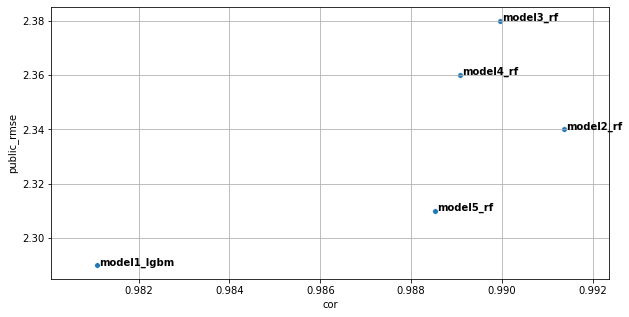

In [ ]:
plt.figure(figsize=(10,5))
# 점의 사이즈가 30인 산점도 그래프
graph = sns.scatterplot(x="cor", y="public_rmse", data=score_df, s=30)
# 각 점에 대한 모델명 표시
for idx in range(0, score_df.shape[0]):
    graph.text(score_df.cor[idx]+0.00005 , score_df.public_rmse[idx]-0.00003, 
               score_df.model[idx], horizontalalignment='left', 
               size='medium', color='black', weight='semibold')

# x축 범위 지정
plt.xlim((score_df.cor.min()-0.001, score_df.cor.max()+0.001))
# y축 범위 지정
plt.ylim((score_df.public_rmse.min()-0.005, score_df.public_rmse.max()+0.005))
plt.grid() # 격자 무늬
plt.show()

#### (2) 여러 가지 앙상블 기법
- 가중산술 평균 : 산술평균에 가중치를 더함
- 멱 평균 : 평균식을 일반화 

#### - 1번째 앙상블 :  임시스코어와 상관계수가 가장 낮은 model1_lgbm과 모델5_rf를 멱평균을 취해 앙상블

In [ ]:
ensemble_dir = "C:/dacon/ch03/submission/Ensemble1/"

# Ensemble1 폴더가 없다면 Ensemble1 폴더를 생성
if not os.path.isdir(ensemble_dir):
    os.mkdir(ensemble_dir)

# Ensemble1 폴더로 파일 이동
import shutil
shutil.move(sub_dir + 'model1_lgbm=2.29.csv', ensemble_dir + 'model1_lgbm=2.29.csv')
shutil.move(sub_dir + 'model5_rf=2.31.csv', ensemble_dir + 'model5_rf=2.31.csv')

# model1_lgbm=2.29.csv, model5_rf=2.31.csv 멱 평균
nf = 0
for f in os.listdir(ensemble_dir):
    ext = os.path.splitext(f)[-1] # 'Ensemble1' 폴더에 있는 파일의 확장자를 분리

    if ext == '.csv':
        sub = pd.read_csv(ensemble_dir + f) # 확장자명이 .csv라면 해당 데이터를 로드
    else:
        continue # 확장자명이 .csv가 아니라면 for문을 종료

    if len(sub.columns) !=2:
        continue # 로드한 데이터의 변수의 수가 2개가 아니라면 for문을 종료

    # 파일의 확장자명이 .csv이고, 변수의 수가 2개인 경우에만 밑의 조건문이 실행됩니다.
    if nf == 0:
        sub_df = sub # nf가 0이면 해당 데이터(sub)를 sub_df 에 저장
    else:
        sub_df = pd.merge(sub_df, sub, on="id") # nf가 0이 아니면 해당 데이터를 sub_df와 병합
    
    nf += 1

p = 21 # 하이퍼파라미터이므로 최적의 값을 찾아야 합니다.

# 파일의 개수(nf)가 2개 이상인 경우에만 밑의 조건문이 실행됩니다.
if nf >= 2: 
    pred = 0
    
    # 앞서 소개한 멱 평균의 식을 나타낸 코드입니다.
    for j in range(nf):
        pred = pred + sub_df.iloc[:,j+1]**p
    pred = pred / nf    
    pred = pred**(1/p)
    
    # 멱 평균 결과를 대입하여 데이터프레임 submit을 생성하고, csv파일로 저장 
    submit = pd.DataFrame({'id': sub_df.id, '18~20_ride': pred})
    fname = "ensemble_model1+model5.csv"
    submit.to_csv(fname, index=False)
    
    print(fname + '가 저장되었습니다!')

ensemble_model1+model5.csv가 저장되었습니다!


#### - 2번째 앙상블 :  임시스코어가 가장 높은 model3_rf를 제거한 model2_f 와 model4_rf를 앙상블 

In [ ]:
ensemble_dir = "C:/dacon/ch03/submission/Ensemble2/"

# Ensemble2 폴더가 없다면 Ensemble2 폴더를 생성
if not os.path.isdir(ensemble_dir):
    os.mkdir(ensemble_dir)

# Ensemble2 폴더로 파일 이동
import shutil
shutil.move(sub_dir + 'model2_rf=2.34.csv', ensemble_dir + 'model2_rf=2.34.csv')
shutil.move(sub_dir + 'model4_rf=2.36.csv', ensemble_dir + 'model4_rf=2.36.csv')

# model2_rf=2.34.csv, model4_rf=2.36.csv 멱 평균
nf = 0
for f in os.listdir(ensemble_dir):
    # 'Ensemble2' 폴더에 있는 파일의 확장자를 분리
    ext = os.path.splitext(f)[-1] 

    if ext == '.csv': 
        # 확장자명이 .csv라면 해당 데이터를 로드
        sub = pd.read_csv(ensemble_dir + f) 
    else: 
        # 확장자명이 .csv가 아니라면 for문을 종료
        continue 

    if len(sub.columns) !=2:
        # 로드한 데이터의 변수의 수가 2개가 아니라면 for 문을 종료
        continue 

    # 파일의 확장자명이 .csv이고, 변수의 수가 2개인 경우에만
    # 밑의 조건문이 실행됩니다.
    if nf == 0:
        sub_df = sub # nf가 0이면 해당 데이터(sub)를 sub_df 에 저장
    else: 
        # nf가 0이 아니면 해당 데이터를 sub_df와 병합
        sub_df = pd.merge(sub_df, sub, on="id") 
    
    nf += 1

p = 21 # 하이퍼파라미터이므로 최적의 값을 찾아야 합니다.

# 파일의 개수(nf)가 2개 이상인 경우에만 밑의 조건문이 실행됩니다.
if nf >= 2: 
    pred = 0
    
    # 앞서 소개한 멱 평균의 식을 나타낸 코드입니다.
    for j in range(nf):
        pred = pred + sub_df.iloc[:,j+1]**p
    pred = pred / nf    
    pred = pred**(1/p)

    # 멱 평균 결과를 대입하여 데이터프레임 submit을 생성하고, csv 파일로 저장
    submit = pd.DataFrame({'id': sub_df.id, '18~20_ride': pred})
    fname = "ensemble_model2+model4.csv"
    submit.to_csv(fname, index=False)
    
    print(fname + '가 저장되었습니다!')

ensemble_model2+model4.csv가 저장되었습니다!


#### - 3번째 앙상블 : 1번째 앙상블파일과 2번째 앙상블파일, 그리고 임시스코어가 가장 높은 model3_rf를 가중산술평균을 통해 앙상블

In [ ]:
# 앙상블 파일 로드
first = pd.read_csv('ensemble_model1+model5.csv')
second = pd.read_csv('ensemble_model2+model4.csv')
third = pd.read_csv('model3_rf=2.38.csv')

# 가중산술평균
w_mean = 0.22*first['18~20_ride'] + 0.30*second['18~20_ride'] + 0.48*third['18~20_ride']

# 최종 submission 파일 생성
sub['18~20_ride'] = w_mean
sub.to_csv('final_submission.csv', index=False)